In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from model import AlexNet
import os
import json
import time
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

In [4]:
# 数据预处理，定义data_transform这个字典
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),  # 随机裁剪，裁剪到224*224
                                 transforms.RandomHorizontalFlip(),  # 水平方向随机翻转
                                 transforms.ToTensor(), 
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    
}

In [8]:
# os.getcwd()获取当前文件所在目录， "../.."返回上上层目录，".."返回上层目录
# data_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # get data root path
data_root = os.path.abspath(os.path.join(os.getcwd()))

In [30]:
data_root

'D:\\DeepLearning\\163\\github\\AlexNet'

In [31]:
# D:\deeplearning
image_path = data_root + "/flower_data/"
train_dataset = datasets.ImageFolder(
    root=image_path + "/train",
    transform=data_transform["train"], 
)

In [32]:
trian_num = len(train_dataset) # trian_num: 3306

In [33]:
flower_list = train_dataset.class_to_idx   
# 获取分类的名称所对应的索引，即{'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}

In [34]:
cla_dict = dict((val, key) for key, val in flower_list.items())

In [35]:
# 将key和value反过来的目的是，预测之后返回的索引可以直接通过字典得到所属类别
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:  # 保存入json文件
    json_file.write(json_str)

In [36]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0 
)

validate_dataset = datasets.ImageFolder(
    root=image_path + "/val",
    transform=data_transform["val"], 
)
validate_loader = torch.utils.data.DataLoader(
    validate_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0 
    
)



In [37]:
print(len(validate_loader))
print(len(train_loader))

12
104


In [45]:
net = AlexNet(num_classes=5).to(device)
import math
save_path = './AlexNet.pth'

In [49]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002)
best_acc = 0.0
Loss = []
Acc = []
for epoch in range(10):
    # train
    net.train()
    running_loss = 0.0
    t1 = time.perf_counter()
    with tqdm(total=math.ceil(len(train_loader))) as train_bar:
        for step, data in enumerate(train_loader, start=0):
            train_bar.update(1)
            images, labels = data
            outputs = net(images.to(device))
            optimizer.zero_grad()
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(time.perf_counter()-t1)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            for data_test in validate_loader:
                test_images, test_labels = data_test
                outputs = net(test_images.to(device))
                outputs.shape
                predict_y = torch.max(outputs, dim=1)[1]
                acc += (predict_y == test_labels.to(device)).sum().item()
            accurate_test = acc / len(validate_dataset)
            if accurate_test > best_acc:
                best_acc = accurate_test
                torch.save(net.state_dict(), save_path)
            Loss.append(running_loss)
            Acc.append(accurate_test)
            print('epoch:', epoch+1, 'train_loss:', round(running_loss / step, 3), 'test_accuracy:', round(accurate_test, 3))
            # train_bar.set_description('epoch:%s train_loss:%.5f test_accuracy： %.5f ' % (epoch + 1, running_loss / step, acc / val_num))
            # print('[epoch %d] train_loss: %.3f  test_accuracy: %.3f' %
            #       (epoch + 1, running_loss / step, acc / val_num))

print('Finished Training')
    

100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:22<00:00,  4.85it/s]

22.467636200000015


  1%|▊                                                                                 | 1/104 [00:00<00:17,  5.97it/s]

epoch: 1 train_loss: 1.005 test_accuracy: 0.613


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:30<00:00,  4.00it/s]

30.241605199999867


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 2 train_loss: 0.955 test_accuracy: 0.607


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:31<00:00,  3.87it/s]

31.815366699999913


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 3 train_loss: 0.957 test_accuracy: 0.637


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:30<00:00,  4.05it/s]

30.312476899999865


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 4 train_loss: 0.878 test_accuracy: 0.629


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:30<00:00,  3.87it/s]

30.389885899999854


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 5 train_loss: 0.845 test_accuracy: 0.654


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:36<00:00,  2.72it/s]

36.0752937000002


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 6 train_loss: 0.833 test_accuracy: 0.64


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:45<00:00,  2.40it/s]

45.61096610000004


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 7 train_loss: 0.827 test_accuracy: 0.687


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:40<00:00,  3.36it/s]

40.5203161999998


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 8 train_loss: 0.777 test_accuracy: 0.698


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:42<00:00,  2.74it/s]

42.38398760000018


  0%|                                                                                          | 0/104 [00:00<?, ?it/s]

epoch: 9 train_loss: 0.766 test_accuracy: 0.676


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:42<00:00,  3.05it/s]

42.919856399999844


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:46<00:00,  2.22it/s]

epoch: 10 train_loss: 0.737 test_accuracy: 0.679
Finished Training


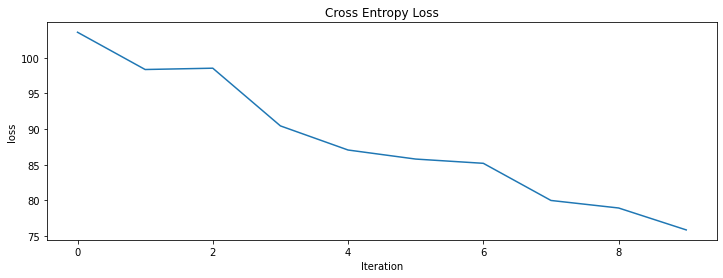

In [50]:
plt.figure(figsize=(12, 4))
plt.plot(Loss)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');


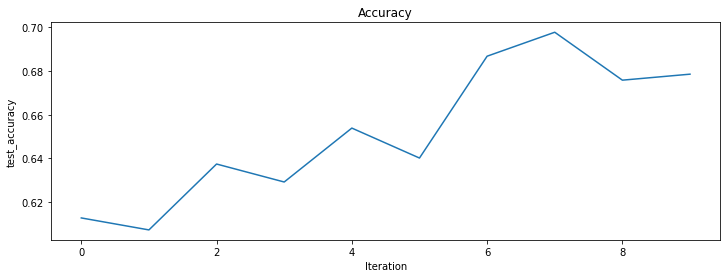

In [51]:
plt.figure(figsize=(12, 4))
plt.plot(Acc)
plt.xlabel('Iteration')
plt.ylabel('test_accuracy')
plt.title('Accuracy');


In [54]:
from math import exp
window_size = 11
sigma = 1.5
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


In [55]:
_1D_window = gaussian(window_size, 1.5).unsqueeze(1)

In [63]:
_1D_window.shape

torch.Size([11, 1])

In [57]:
gaussian(window_size, 1.5)

tensor([0.0010, 0.0076, 0.0360, 0.1094, 0.2130, 0.2660, 0.2130, 0.1094, 0.0360,
        0.0076, 0.0010])

In [60]:
_2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)

In [61]:
_2D_window.shape

torch.Size([1, 1, 11, 11])

In [64]:
from torch.autograd import Variable

In [68]:
window = Variable(_2D_window.expand(10, 1, window_size, window_size).contiguous())

In [69]:
window.shape

torch.Size([10, 1, 11, 11])